In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
import random

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

In [3]:
base_dir = '../data/Category_and_Attribute_Prediction_Benchmark'

# Load category annotations
category_img = pd.read_csv('../data/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_img.txt', sep='\s+', skiprows=2, header=None)
category_img.columns = ['image_name', 'category_label']

# Load category names
category_names = pd.read_csv('../data/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_category_cloth.txt', sep='\s+', skiprows=1, header=None)
category_names.columns = ['category_name', 'category_type']

# Merge category names with image annotations
category_img = category_img.merge(category_names, left_on='category_label', right_index=True)

# Load attribute annotations
attr_img = pd.read_csv('../data/Category_and_Attribute_Prediction_Benchmark/Anno_coarse/list_attr_img.txt', sep='\s+', skiprows=2, header=None)
attr_img.columns = ['image_name'] + [f'attr_{i+1}' for i in range(attr_img.shape[1] - 1)]

category_img['image_name'] = category_img['image_name'].str.replace('img/', 'img_highres/')
attr_img['image_name'] = attr_img['image_name'].str.replace('img/', 'img_highres/')
print(category_img['image_name'].head())
print(attr_img['image_name'].head())

# Merge with category data
dataset = pd.merge(category_img, attr_img, on='image_name')
print(len(dataset))

0    img_highres/Sheer_Pleated-Front_Blouse/img_000...
1    img_highres/Sheer_Pleated-Front_Blouse/img_000...
2    img_highres/Sheer_Pleated-Front_Blouse/img_000...
3    img_highres/Sheer_Pleated-Front_Blouse/img_000...
4    img_highres/Sheer_Pleated-Front_Blouse/img_000...
Name: image_name, dtype: object
0    img_highres/Sheer_Pleated-Front_Blouse/img_000...
1    img_highres/Sheer_Pleated-Front_Blouse/img_000...
2    img_highres/Sheer_Pleated-Front_Blouse/img_000...
3    img_highres/Sheer_Pleated-Front_Blouse/img_000...
4    img_highres/Sheer_Pleated-Front_Blouse/img_000...
Name: image_name, dtype: object
289222


# Subset the Dataset
Filter a smaller subset of the dataset (e.g., 4,000 images) for training to reduce computational cost:

In [7]:
# Sample a subset of the dataset
subset = dataset.sample(n=36153, random_state=42)  # Adjust size as needed

# Split the subset into train+validation and test sets
train_val_df, test_df = train_test_split(subset, test_size=0.1, random_state=42)

print(f"Train+Validation size: {len(train_val_df)}")
print(f"Test size: {len(test_df)}")

# Split the dataset to chunks 
chunk_size = 4000

# Sample a subset of the dataset
shuffled_dataset = train_val_df.sample(frac=1, random_state=42).reset_index(drop=True)
chunks = [shuffled_dataset.iloc[i:i + chunk_size] for i in range(0, len(shuffled_dataset), chunk_size)]

# Check number of chunks
print(f"Number of chunks: {len(chunks)}")
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1} size: {len(chunk)}")

Train+Validation size: 32537
Test size: 3616
Number of chunks: 9
Chunk 1 size: 4000
Chunk 2 size: 4000
Chunk 3 size: 4000
Chunk 4 size: 4000
Chunk 5 size: 4000
Chunk 6 size: 4000
Chunk 7 size: 4000
Chunk 8 size: 4000
Chunk 9 size: 537


In [9]:
# Define the model
def create_model(num_classes):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')  # Match the number of classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Data generator for preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Train on each chunk
for i, chunk in enumerate(chunks):
    print(f"Training on chunk {i+1}/{len(chunks)}")
    
     # Split chunk into training and validation sets
    train_chunk, val_chunk = train_test_split(chunk, test_size=0.2, random_state=42)

    train_classes = set(train_chunk['category_name'])
    val_classes = set(val_chunk['category_name'])

    common_classes = train_classes.intersection(val_classes)
    print(f"Common classes: {len(common_classes)}")
    
    # Filter datasets to include only common classes
    train_chunk = train_chunk[train_chunk['category_name'].isin(common_classes)]
    val_chunk = val_chunk[val_chunk['category_name'].isin(common_classes)]
    
    # Data generators for this chunk
    train_data = datagen.flow_from_dataframe(
        train_chunk,
        directory='../data/Category_and_Attribute_Prediction_Benchmark/Img/',
        x_col='image_name',
        y_col='category_name',
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical'
    )

    val_data = datagen.flow_from_dataframe(
        val_chunk,
        directory='../data/Category_and_Attribute_Prediction_Benchmark/Img/',
        x_col='image_name',
        y_col='category_name',
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical'
    )

    # Initialize the model
    model = create_model(num_classes=len(train_data.class_indices))

    # Train the model on this chunk
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=15,  # Train for 10–15 epochs per chunk
        steps_per_epoch=len(train_data)//32,
        validation_steps=len(val_data)//32
    )
    
    # Save the model weights after training on this chunk
    model.save_weights(f"xception_weights_chunk_{i+1}.weights.h5")

Training on chunk 1/9
Common classes: 31
Found 3168 validated image filenames belonging to 31 classes.
Found 800 validated image filenames belonging to 31 classes.
Epoch 1/15


/Users/dalenlim/cs310/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 13s/step - accuracy: 0.1016 - loss: 3.4470 - val_accuracy: 0.2725 - val_loss: 3.5308
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.1745 - loss: 3.1334 - val_accuracy: 0.2925 - val_loss: 5.4966
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.2630 - loss: 2.8213 - val_accuracy: 0.2763 - val_loss: 7.5419
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.2708 - loss: 2.4865 - val_accuracy: 0.2800 - val_loss: 7.4553
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.2617 - loss: 2.6062 - val_accuracy: 0.2837 - val_loss: 5.2041
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2461 - loss: 2.7064 - val_accuracy: 0.3013 - val_loss: 6.0216
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2539 - loss: 2.7276 - val_accuracy: 0.2962 - val_loss: 3.6750
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.2839 - loss: 2.6833 - val_accuracy: 0.2850 - val_loss: 3.7977
Epoch 9/15
3/3 ━━━━━━━

/Users/dalenlim/cs310/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 123s 21s/step - accuracy: 0.0755 - loss: 3.3472 - val_accuracy: 0.2550 - val_loss: 5.5369
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.1471 - loss: 3.2656 - val_accuracy: 0.1262 - val_loss: 6.4029
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.1732 - loss: 3.1634 - val_accuracy: 0.2550 - val_loss: 5.1748
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 11s/step - accuracy: 0.2643 - loss: 2.8666 - val_accuracy: 0.2550 - val_loss: 9.3375
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.2682 - loss: 2.6404 - val_accuracy: 0.2550 - val_loss: 9.9013
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.2409 - loss: 2.9281 - val_accuracy: 0.2575 - val_loss: 7.1361
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - accuracy: 0.2826 - loss: 2.7443 - val_accuracy: 0.2625 - val_loss: 7.5374
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.3190 - loss: 2.3774 - val_accuracy: 0.2587 - val_loss: 8.3871
Epoch 9/15
3/3 ━

/Users/dalenlim/cs310/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [ ]:
# Combine a fraction of all chunks for final training
final_train_df = pd.concat(chunks[:2])  # Combine the first two chunks (or any desired fraction)

# Split into train and validation sets
final_train_chunk, final_val_chunk = train_test_split(final_train_df, test_size=0.2, random_state=42)

final_train_classes = set(final_train_chunk['category_name'])
final_val_classes = set(final_val_chunk['category_name'])

common_classes = final_train_classes.intersection(final_val_classes)
print(f"Common classes: {len(common_classes)}")

final_train_chunk = final_train_chunk[final_train_chunk['category_name'].isin(common_classes)]
final_val_chunk = final_val_chunk[final_val_chunk['category_name'].isin(common_classe)]

# Data generators for final training
final_train_data = datagen.flow_from_dataframe(
    final_train_chunk,
    directory='../data/Category_and_Attribute_Prediction_Benchmark/Img/',
    x_col='image_name',
    y_col='category_name',
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical'
)
final_val_data = datagen.flow_from_dataframe(
    final_val_chunk,
    directory='../data/Category_and_Attribute_Prediction_Benchmark/Img/',
    x_col='image_name',
    y_col='category_name',
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical'
)

# Initialize the model for final training
final_model = create_model(num_classes=len(final_train_data.class_indices))

# Optionally, load the weights from the last chunk
final_model.load_weights("xception_weights_chunk_8.h5")  # Adjust based on the last chunk

# Train the model for 100 epochs
final_history = final_model.fit(
    final_train_data,
    validation_data=final_val_data,
    epochs=100,  # Longer final training
    steps_per_epoch=len(final_train_data)//64,
    validation_steps=len(final_val_data)//64
)

# Save the final model
final_model.save("xception_final_model.h5")


In [13]:
# Test data generator
test_data = datagen.flow_from_dataframe(
    test_df,
    directory='../data/Category_and_Attribute_Prediction_Benchmark/Img/',
    x_col='image_name',
    y_col='category_name',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model on the test dataset
test_results = final_model.evaluate(test_data)
print(f"Test Accuracy: {test_results[1]:.2f}")

Found 5084 validated image filenames belonging to 32 classes.
Found 1276 validated image filenames belonging to 32 classes.
Found 1590 validated image filenames belonging to 32 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


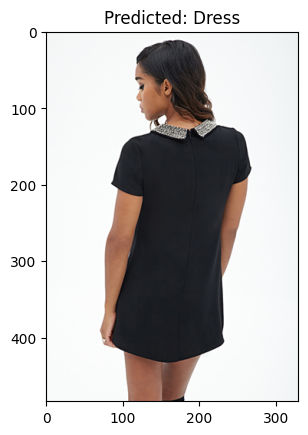

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


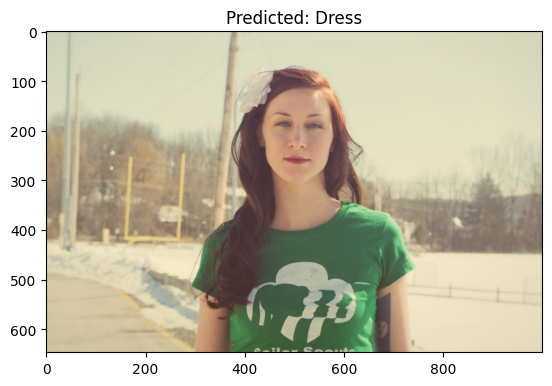

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


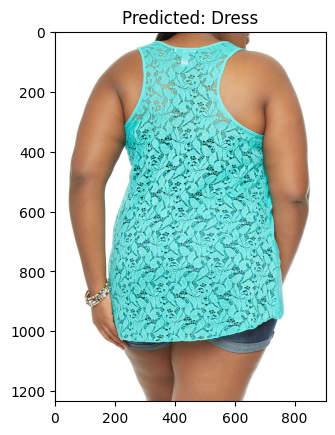

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


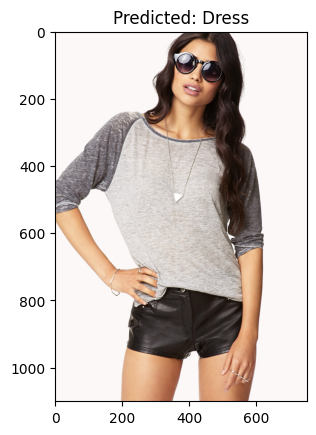

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


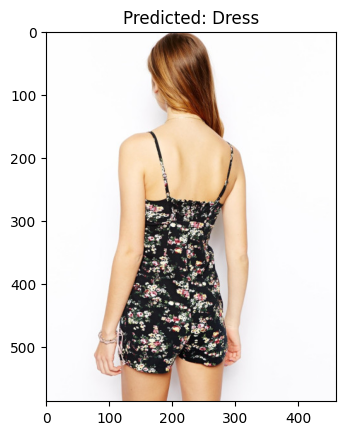

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


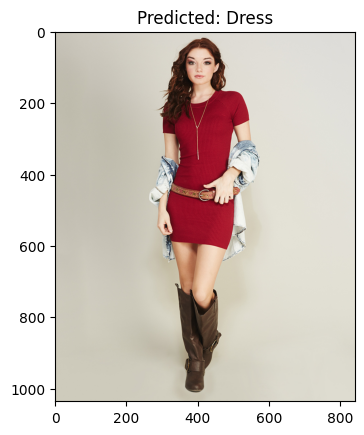

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


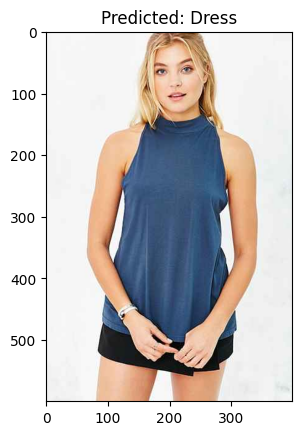

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


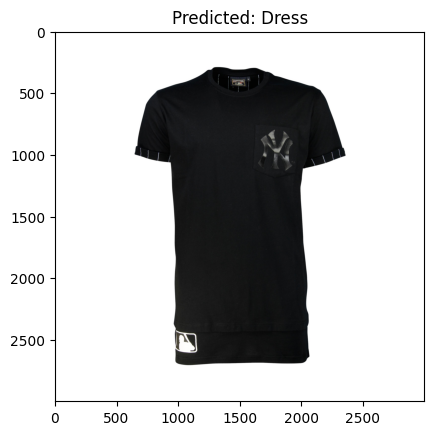

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


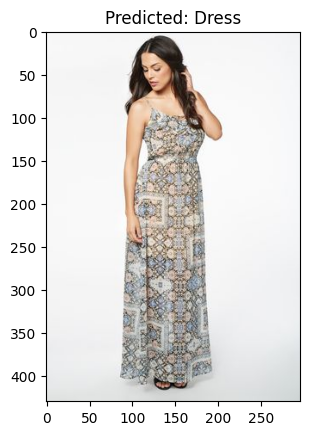

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


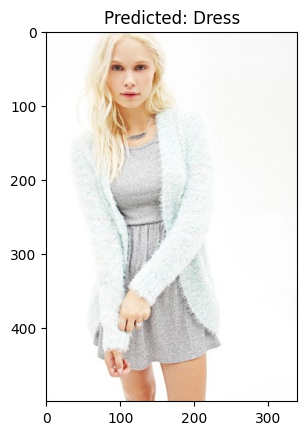

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Predict function
def predict_image(image_path, model):
    image = load_img(image_path, target_size=(100, 100))
    image = img_to_array(image) / 255.0
    image = image.reshape(1, 100, 100, 3)
    prediction = model.predict(image)
    predicted_class = list(final_train_data.class_indices.keys())[np.argmax(prediction)]
    return predicted_class

# Visualize predictions
for i, row in test_df.sample(5).iterrows():
    img_path = '../data/Category_and_Attribute_Prediction_Benchmark/Img/' + row['image_name']
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predict_image(img_path, model)}")
    plt.show()